# Determining the best fitting Linear Regression model

##### Steps taken:
1. (PRELIM) Convert statistics attributes to useful measures -- eg. comment to view ratio > total number of comments or views
2. (PRELIM) Convert other data into meaninful information that can be used in the model building
    - convert all columns to the same dtype: float or int
3. (PRELIM) Drop all unnecessary columns after conversions, and clean up the DF
4. Check for multicolinearity via a correlation matrix with the predictor attributes and take necessary action
    - alternatively, a Pairwise Scatter plot can be used to visually examine linearity
5. Check for correlation of each predictor variable to the outcome
6. Drop attributes that have no significant correlation (p value of pearson correlation > 0.05)
    - If no variables display significant correlation to the outcome, try new categories/statistics
        - If this proves ineffective, try using a different data, or adding more data if sparcity isn't a concern
7. Split Data into predictors (X) and outcome (y)
8. Feature Scaling of the predictor values
9. Split into testing and training sets
10. Fit a linear regression model with all statistically significant predictor variables from the training dataset
11. Fit Linear, Ridge, Lasso, and ElasticNet Regression models
12. Create a cross-validation grid-search to obtain the best model for each form of Regression
    - obtain the best parameters for each model
13. For each model, fit the testing data and calculate the error -- either the RSS, MAE, MSE, MAPE, MPE, or RMSE
14. Compare all models by their error (probably RMSE is best) and select the best model
15. (optional) to decrease model error, find more attributes, alter the existing attributes, or increase the data
16. Use the optomised model to make predictions on new data

NOTE: This file shall be created to streamline the process of deciding which linear model best fits your dataset with continuous and/or ordinal categorical values. 

** This file was not created to support binary predictor variables or non-ordinal categorical data. If necessary, you can create dummy variables and add them to the X - predictors after scaling is completed

*** PRELIM = Preliminary steps

Prerequisite: A cleaned, ready to run pandas dataframe

In [1]:
# General imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Imports needed for Regression modeling

import seaborn as sns # for correlation matrix/pairwise scatter plotting

# The linear Regression models I'll be comparing
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.model_selection import GridSearchCV # Cross validation Grid search for parameter-error optomization 

from sklearn.metrics import mean_squared_error as mse # The chosen cost metric for measuring and comparing model error

from scipy.stats import pearsonr # Calculating P-values for correlation

from sklearn.preprocessing import scale # Feature scaling/Normalization

from sklearn.model_selection import train_test_split # For testing/training set splitting

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Import the cleaned, ready to run DF
cleaned_df = pd.read_csv('filename.csv') # Alternatively import an xlsx, etc...

In [ ]:
# Necessary parameters -- after filling out these you should be able to run the rest of the notebook with no further input

outcome = 'columnname' # Input the column name of your outcome variable
test_set_size = 0.2 # Input what proportion of your data to allocate to the testing set -- 20% is standard
random = 33 # Input a random state 
alpha_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10, 20, 40, 60, 100, 200, 300, 500] # trial alpha parameters
params = {'alpha': alpha_values} # list of alpha to tune with the above trial numbers
folds_number = 5 # Set the number of Cross-Validation (CV) folds

In [ ]:
# Visually inspect the Pairwise Scatterplot for linear relationships between predictor variables

# If your dataset has more than 1,000 observations, 1,000 will be set for the sample size in the pairwise scatterplot
# as this is more than enough to assess linearity

def sample_size(df):
    if len(df) >= 1000:
        ss = 1000
    else:
        ss = len(df)
    return ss

ss = sample_size(cleaned_df)
sns.pairplot(cleaned_df.sample(ss))

In [ ]:
# Another set of pairwise scatterplots with regression lines fit for more clarity

sns.set(style="ticks", color_codes=True)
g = sns.pairplot(cleaned_df, kind="reg", plot_kws={'line_kws':{'color':'red'}})
plt.show()

In [ ]:
# correlation matrix heatmap

corr = cleaned_df.corr()
plt.figure(figsize=(16,8))
sns.heatmap(corr, cmap='cividis', annot=True)

plt.show()

In [ ]:
# Pearson r p-value calculations between each predictor and the outcome

def get_p_values(df):
    p_values = {}
    for column in df.columns:
        correlate, p_value = pearsonr(df[outcome], df[column])
        p_values[column] = [correlate, p_value]
    del p_values[outcome]
    return p_values
        

p_values = get_p_values(cleaned_df)
p_values = pd.DataFrame.from_dict(p_values).T.rename(columns = {0:'Correlate', 1:'p_value'}).round({'Correlate': 3, 'p_value':4})
p_values # Consider dropping all variables that have little significance (p > 0.05) in their association to the outcome

In [ ]:
# Splitting the data into predictors (X) and outcome (y)
# I automatically removed predictor variables with p-values of > 0.05, you can manually change this if you so choose

significant = p_values[p_values['p_value'] <= 0.05].index.tolist()
X = cleaned_df[significant]
y = cleaned_df[[outcome]]

In [ ]:
# Feature Scaling/Normalization

X = pd.DataFrame(scale(X), columns = X.columns)

In [ ]:
# Splitting into training/testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_set_size, random_state = random) 

# Double checking appropriate splitting by assessing sizes of test/training sets

X_train.shape, X_test.shape, y_train.shape, y_test.shape

## Linear Regression
### Basic Linear Regression with no CV/hyperparameter tuning

In [210]:
lm = LinearRegression() # Standard LR Model with no hyperparameters or cross-validation
model = lm.fit(X,y)

## Ridge Regression (L2 Regularization)
### Cross Validation and Hyperparameter Tuning

In [245]:
# Instantiating the Ridge class

ridge = Ridge()

# Creating the CV grid-search to find an optimal model

grid_cv_model = GridSearchCV(estimator = ridge,
                       param_grid = params,
                       scoring='neg_mean_absolute_error', # Taking the negative MAE since this model is based on cost function
                       cv = folds_number, 
                       return_train_score = True,
                       verbose = 1)

# fiting the grid-search with the training data

grid_cv_model.fit(X_train, y_train)

# Saving GridSearchCV results into a dataframe 

cv_results = pd.DataFrame(grid_cv_model.cv_results_)

# cv_results head

cv_results.head()

Fitting 5 folds for each of 17 candidates, totalling 85 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.007279,0.001946,0.004017,0.000713,0,{'alpha': 0},-6258.836206,-6670.842017,-6478.170924,-6741.473686,...,-6683.093987,336.30265,1,-6895.443565,-6703.246976,-6783.662544,-6643.452136,-6362.237206,-6677.608485,178.875721
1,0.008129,0.005349,0.004323,0.005840,0.0,{'alpha': 1e-08},-6258.836206,-6670.842017,-6478.170924,-6741.473686,...,-6683.093987,336.30265,2,-6895.443565,-6703.246976,-6783.662544,-6643.452136,-6362.237206,-6677.608485,178.875721
2,0.009696,0.004100,0.002656,0.001515,0.0,{'alpha': 1e-07},-6258.836206,-6670.842017,-6478.170924,-6741.473686,...,-6683.093987,336.30265,3,-6895.443565,-6703.246976,-6783.662544,-6643.452136,-6362.237206,-6677.608485,178.875721
3,0.003125,0.006251,0.000000,0.000000,0.000001,{'alpha': 1e-06},-6258.836206,-6670.842017,-6478.170924,-6741.473686,...,-6683.093987,336.30265,4,-6895.443565,-6703.246976,-6783.662544,-6643.452136,-6362.237206,-6677.608485,178.875721
4,0.012500,0.006250,0.000000,0.000000,0.00001,{'alpha': 1e-05},-6258.836206,-6670.842017,-6478.170924,-6741.473686,...,-6683.093987,336.30265,5,-6895.443565,-6703.246976,-6783.662544,-6643.452136,-6362.237206,-6677.608485,178.875721


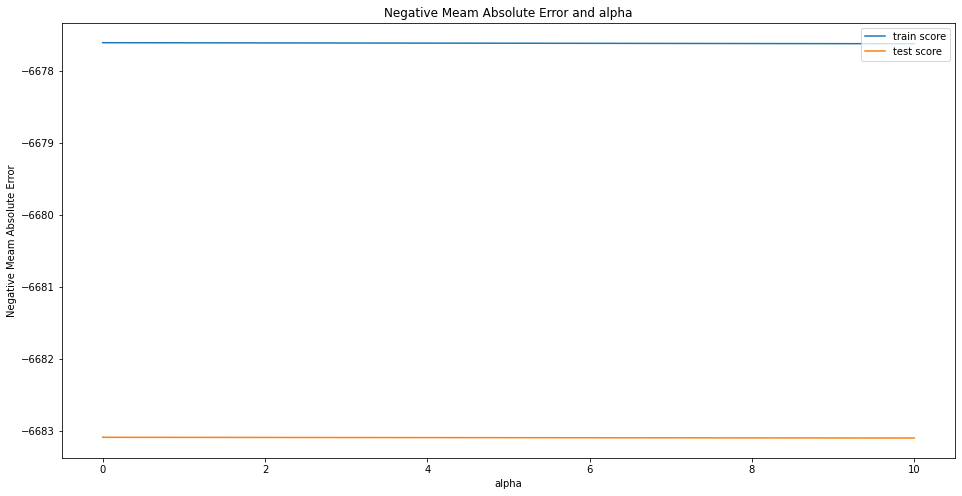

In [236]:
# Plotting coding -- plotting helps visualize the best alpha to minimize negative MAE values 
# changing datatype of 'param_alpha' into int for plotting

cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting

plt.figure(figsize=(16,8))
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])

plt.title('Negative Meam Absolute Error and alpha')
plt.xlabel('alpha')
plt.ylabel('Negative Meam Absolute Error')
plt.legend(['train score','test score'], loc='upper right')

plt.show()

In [235]:
# Finding the optimal alpha from the model -- this should be confirmed with the above plot

best_param_ridge = grid_cv_model.best_params_['alpha']

{'alpha': 0}

In [ ]:
# A quick check to see if the alpha values need updating

if best_param_ridge == max(alpha_values):
    print('Consider updating the alpha parameter list for the ridge regression, as the best parameter is equal to the max alpha')
elif best_param_ridge == min(alpha_values):
    print('Consider updating the alpha parameter list for the ridge regression, as the best parameter is equal to the min alpha')
else:
    print('The best alpha parameter fit with grid-search CV is:', str(best_param_ridge))

In [253]:
# set the alpha to the best alpha parameter from the grid-search

alpha = best_param_ridge

# Initialising Ridge() with above alpha

ridge = Ridge(alpha = alpha)

#fitting the model with optimal alpha

ridge.fit(X_train, y_train)

Ridge(alpha=0)

## Lasso
### Cross Validation and Hypermarameter Tuning

In [238]:
# Initialising Lasso()

lasso = Lasso()

#using same attributes used for Ridge tuning except estimator here would be lasso

grid_cv_model = GridSearchCV(estimator = lasso,
                       param_grid = params,
                       scoring = 'neg_mean_absolute_error',
                       cv = folds_number,
                       return_train_score = True,
                       verbose = 1)
#fiting model_cv

grid_cv_model.fit(X_train, y_train)

# Saving model_cv results into a dataframe

cv_results = pd.DataFrame(grid_cv_model.cv_results_)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


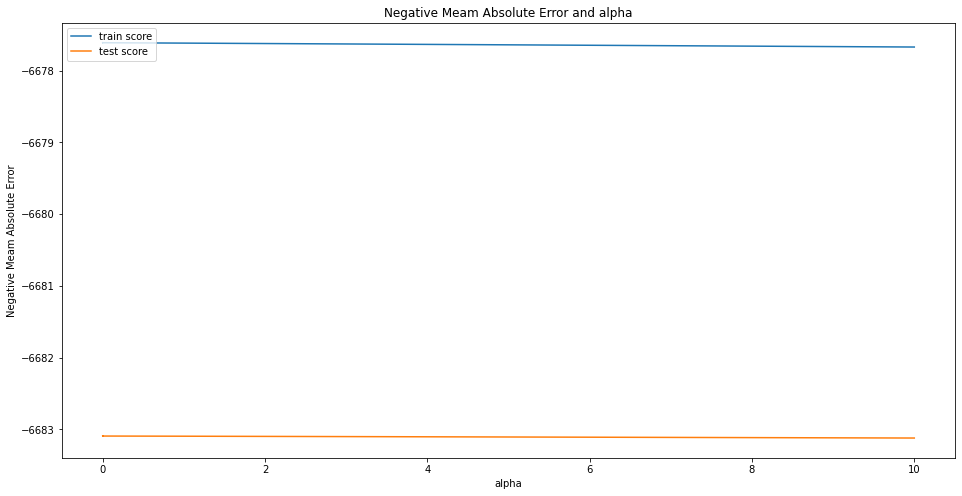

In [239]:
# changing param_alpha datatype to float for plotting

cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting

plt.figure(figsize=(16,8))
plt.plot(cv_results['param_alpha'],cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'],cv_results['mean_test_score'])

plt.title('Negative Meam Absolute Error and alpha')
plt.xlabel('alpha')
plt.ylabel('Negative Meam Absolute Error')
plt.legend(['train score','test score'],loc='upper left')

plt.show()

In [240]:
# Checking best alpha from model_cv

best_param_lasso = grid_cv_model.best_params_['alpha']

{'alpha': 1e-05}

In [ ]:
# A quick check to see if the alpha values need updating

if best_param_lasso == max(alpha_values):
    print('Consider updating the alpha parameter list for the ridge regression, as the best parameter is equal to the max alpha')
elif best_param_lasso == min(alpha_values):
    print('Consider updating the alpha parameter list for the ridge regression, as the best parameter is equal to the min alpha')
else:
    print('The best alpha parameter fit with grid-search CV is:', str(best_param_lasso))

In [251]:
# Seting alpha 

alpha = best_param_lasso

# Defining lasso with above alpha

lasso = Lasso(alpha = alpha)
  
# fiting lasso

lasso.fit(X_train, y_train)

Lasso(alpha=1e-05)

## ElasticNet Regression
### Cross Validation and Hyperparameter Tuning

In [246]:
# Initialising ElasticNet()

elasticnet = ElasticNet() 

# using same attributes used for Ridge tuning except estimator here would be ElasticNet

grid_cv_model = GridSearchCV(estimator = elasticnet,
                       param_grid = params,
                       scoring = 'neg_mean_absolute_error',
                       cv = folds_number,
                       return_train_score = True,
                       verbose = 1)
#fitingmodel_cv

grid_cv_model.fit(X_train, y_train)

# Saving model_cv results into a dataframe

cv_results = pd.DataFrame(grid_cv_model.cv_results_)

Fitting 5 folds for each of 17 candidates, totalling 85 fits


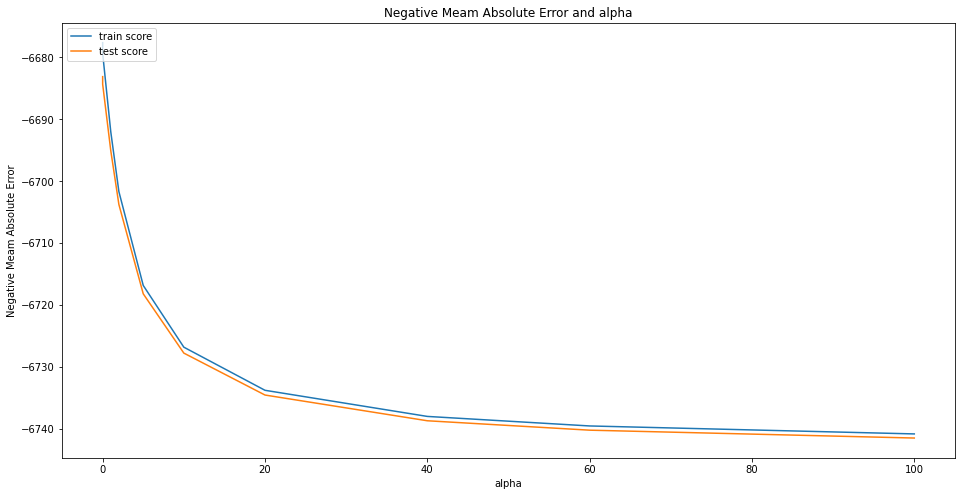

In [247]:
# change param_alpha datatype to float for plotting

cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting

plt.figure(figsize=(16,8))
plt.plot(cv_results['param_alpha'],cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'],cv_results['mean_test_score'])

plt.title('Negative Meam Absolute Error and alpha')
plt.xlabel('alpha')
plt.ylabel('Negative Meam Absolute Error')
plt.legend(['train score','test score'],loc='upper left')

plt.show()

In [248]:
# Checking best  alpha from model_cv

best_param_ElasticNet = grid_cv_model.best_params_['alpha']

{'alpha': 0}

In [ ]:
# A quick check to see if the alpha values need updating

if best_param_ElasticNet == max(alpha_values):
    print('Consider updating the alpha parameter list for the ridge regression, as the best parameter is equal to the max alpha')
elif best_param_ElasticNet == min(alpha_values):
    print('Consider updating the alpha parameter list for the ridge regression, as the best parameter is equal to the min alpha')
else:
    print('The best alpha parameter fit with grid-search CV is:', str(best_param_ElasticNet))

In [249]:
# Seting alpha

alpha = best_param_ElasticNet

# Defining ElasticNet with above alpha

elasticnet = ElasticNet(alpha = alpha)
  
# fiting elastic net

elasticnet.fit(X_train, y_train)

ElasticNet(alpha=0)

## Model Evaluation
Compare all three optomized models via their RMSE

In [254]:
# Using each of the fit models to predict the test set

pred_by_reg = model.predict(X_test)
pred_by_lasso =  lasso.predict(X_test)
pred_by_ridge = ridge.predict(X_test)
pred_by_elasticnet = elasticnet.predict(X_test)

In [255]:
# printing the calculated RMSE for all 3 models

Reg_RMSE = round(np.sqrt(mse(y_test, pred_by_reg)), 3)
lasso_RMSE = round(np.sqrt(mse(y_test, pred_by_lasso)), 3)
ridge_RMSE = round(np.sqrt(mse(y_test, pred_by_ridge)), 3)
ElasticNet_RMSE = round(np.sqrt(mse(y_test, pred_by_elasticnet)), 3)

print(f'Reg RMSE: {Reg_RMSE}')
print(f'Lasso RMSE: {lasso_RMSE}')
print(f'Ridge RMSE: {ridge_RMSE}')
print(f'ElasticNet RMSE: {ElasticNet_RMSE}')

Reg RMSE: 33708.77399281265
Lasso RMSE: 33730.99125435948
Ridge RMSE: 33730.99125455468
ElasticNet RMSE: 33730.99125455468


In [ ]:
alphas = ['best_param_lasso','best_param_ridge','best_param_ElasticNet']
alphas_to_vals = {}
for alpha in alphas:
  alphas_to_vals[alpha] = eval(alpha)

all_models = {'regular':Reg_RMSE, 'lasso':lasso_RMSE, 'ridge':ridge_RMSE, 'ElasticNet':ElasticNet_RMSE}
best_model = min(all_models, key = all_models.get)

if best_model != 'regular':
    best_param = alphas_to_vals['best_param_'+best_model]
else:
    best_param = 'NaN - Regular Regression has no optomized alpha'

if best_param != 'NaN - Regular Regression has no optomized alpha':
    print('The Regression that minimizes the RMSE is the', best_model, 'regression with an alpha of', best_param)
else:
    print('The Regression that minimizes the RMSE is the', best_model, 'regression')

In [ ]:
# Creating a DF that displays the the true vs predicted values and their percent difference

preds = ['pred_by_reg', 'pred_by_lasso','pred_by_ridge','pred_by_elasticnet']
preds_to_vals = {}
for pred in preds:
  preds_to_vals[pred] = eval(pred)

best_model_predictions = preds_to_vals['pred_by_'+best_model]
best_model_predictions

listt = []
for num in range(0, len(best_model_predictions.tolist())):
    listt.append(best_model_predictions.tolist()[num][0])

prediction_df = X_test.copy()
prediction_df = prediction_df.reset_index(drop = True)
true_vals = y_test.copy()
true_vals = true_vals.reset_index(drop = True)

prediction_df = pd.merge(prediction_df, true_vals, left_index = True, right_index = True)
prediction_df['predicted_values'] = listt

prediction_df = prediction_df.rename(columns = {outcome:'true_values'})
prediction_df['difference_percent'] = (prediction_df['true_values'] - prediction_df['predicted_values'])/prediction_df['true_values']

prediction_df = prediction_df[['true_values', 'predicted_values', 'difference_percent']]
prediction_df.head(5)

In [ ]:
mean_error = round(abs(prediction_df['difference_percent']).mean(), 3)
max_error = round(abs(prediction_df['difference_percent']).max(), 3)
min_error = round(abs(prediction_df['difference_percent']).min(), 3)
std_error = round(abs(prediction_df['difference_percent']).std(), 3)

print('The absolute mean percent error between the predicted and true values is:', str(mean_error))
print('The absolute standard deviation of percent error is:', str(std_error))
print('The absolute greatest deviation percent error is:', str(max_error))
print('The absolute least percent error is:', str(min_error))